## Merger Simulations; Testing with PCAIDS Model Post-Merger Outcomes in the European Automobile Sector

### Tilburg University 

### MSc Thesis Economics


### Author: Borja Casado


### Supervisor: Jan Boone

This notebook is meant to serve as illustration of what must be done when assessing mergers using PCAIDS. The simulation code is Jan Boone's, current Tilburg University Professor. See more http://janboone.github.io/competition_policy_and_regulation/Mergers/Mergers.html 

Import the necesseary libraries

In [1]:
from scipy import optimize,arange
from sympy import *
from sympy.solvers.solveset import linsolve
import sympy as sy
sy.init_printing()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import log
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Always display all the columns
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60) 

Load the data into de Notebook. First, Verboven's dataset regarding the European Car Market, then copper yeary data and steel yearly data.

In [3]:
#We rename pop because python thinks it's a function when we use df_peugeot.pop, for example
df = pd.read_csv('CarsUpdated.csv', encoding='latin-1').rename(index=str, columns={"pop": "population"})

df['year'] = 1900+df.ye


#We import copper prices historical data

df_copper = pd.read_csv('copper-prices-historical-chart-data.csv', encoding='latin-1')

#Steel

df_steel = pd.read_csv('steelprice.csv', encoding='latin-1').rename(index=str, columns={"DATE": "date"})

We need to clean copper and steel data first, we reformat the datetime to merge them as columns in the main dataset.

In [9]:
cols_steel = df_steel.columns.tolist()
cols_steel = cols_steel[-1:] + cols_steel[:-1]
df_steel = df_steel[cols_steel]  #    OR    df = df.ix[:, cols]

In [8]:
df_steel['date'] = pd.to_datetime(df_steel['date'])
df_steel['year'] = df_steel.date.dt.year
df_steel2 = df_steel[(df_steel.year.isin(year_selection))] 
df_steel = df_steel2
steel_yearly = pd.DataFrame(df_steel.groupby('year')['WPU101'].mean())


In [10]:
#We convert the dataframe so that we could filter by years (and get the years we need) in the following cell 

df_copper['date'] = pd.to_datetime(df_copper['date'])
df_copper['year'] = df_copper.date.dt.year
copper_yearly = pd.DataFrame(df_copper.groupby('year')[' value'].mean())

#Converting the price shown in the dataset to Euros

eurprice = df['eurpr'] *  1.2956
df['eurprice'] = eurprice
gdppp = df['engdpc'] * 1.2956
df['gdppp'] = gdppp

revenue = df['eurprice'] * df['qu']
df['revenue'] = revenue


Merge copper and steel as columns into the main dataset

In [11]:
df_merged = df.merge(copper_yearly.reset_index(), on = 'year', how = 'left')
df_merged['l_copper_pr'] = np.log(df_merged[' value'])

In [8]:
df_merged = df_merged.merge(steel_yearly.reset_index(), on = 'year', how = 'left')
df_merged.head()

,ye,ma,co,zcode,brd,type,brand,model,org,loc,cla,home,frm,qu,cy,hp,we,pl,do,le,wi,he,li1,li2,li3,li,sp,ac,pr,princ,eurpr,exppr,avexr,avdexr,avcpr,avppr,avdcpr,avdppr,xexr,tax,population,ngdp,rgdp,engdp,ergdp,engdpc,ergdpc,year,eurprice,gdppp,revenue,value,l_copper_pr,WPU101
0,83,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,729,1351.0,58.0,890,5.0,5.0,401.5,161.0,130.5,5.8,7.9,9.6,7.766667,165.0,NaN,336250.0,0.791498,6078.4268,203.87891,1649.2633,55.318588,62.716667,71.460587,80.779312,100.430120,0.033541,0.25,9860000,4188800024576,5.453800e+12,75721383936,9.858893e+10,7679.6533,9998.8770,1983,7875.209762,9949.758815,5.741028e+06,0.726369,-0.319697,101.300000
1,84,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,1860,1351.0,58.0,890,5.0,5.0,401.5,161.0,130.5,5.8,7.9,9.6,7.766667,165.0,11.5,348750.0,0.762016,5859.4341,191.85239,1817.8038,59.519402,69.491669,78.824608,85.906792,108.032960,0.032742,0.25,9860000,4512599769088,5.588500e+12,75817287680,9.389375e+10,7689.3799,9522.6934,1984,7591.482820,9962.360598,1.412016e+07,0.619753,-0.478435,105.275000
2,85,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,1771,1351.0,58.0,890,5.0,5.0,401.5,161.0,130.5,5.8,7.9,9.6,7.766667,165.0,11.5,361000.0,0.736278,6126.1470,188.41115,1916.0225,58.927742,75.891663,84.895088,90.088455,110.849950,0.030755,0.25,9860000,4834399879168,5.644800e+12,82039455744,9.579190e+10,8320.4316,9715.2031,1985,7937.036053,10779.951181,1.405649e+07,0.614674,-0.486664,104.800000
3,86,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,2047,1351.0,58.0,890,5.0,5.0,401.5,161.0,134.5,5.8,7.9,9.6,7.766667,167.0,11.5,339900.0,0.659091,6559.1782,196.10138,1733.2871,51.820515,80.308334,85.047867,91.255554,98.115952,0.029897,0.25,9860000,5084899966976,5.729000e+12,98125234176,1.105547e+11,9951.8496,11212.4410,1986,8498.071276,12893.616342,1.739555e+07,0.619973,-0.478079,101.158333
4,87,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,Fiat,2147,1351.0,58.0,910,5.0,5.0,401.5,161.0,134.5,5.8,8.0,10.0,7.933333,167.0,11.5,349900.0,0.649315,7272.0664,208.72353,1676.3802,48.115623,84.116669,87.594215,92.674103,93.251350,0.028702,0.25,9870000,5318699909120,5.864300e+12,110539980800,1.218793e+11,11199.5930,12348.4640,1987,9421.689228,14510.192691,2.022837e+07,0.770025,-0.261333,104.566667


In [9]:
#Convert into log

df_merged['l_steel_pr'] = np.log(df_merged['WPU101'])


In [10]:
df_merged.head()

,ye,ma,co,zcode,brd,type,brand,model,org,loc,cla,home,frm,qu,cy,hp,we,pl,do,le,wi,he,li1,li2,li3,li,sp,ac,pr,princ,eurpr,exppr,avexr,avdexr,avcpr,avppr,avdcpr,avdppr,xexr,tax,population,ngdp,rgdp,engdp,ergdp,engdpc,ergdpc,year,eurprice,gdppp,revenue,value,l_copper_pr,WPU101,l_steel_pr
0,83,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,729,1351.0,58.0,890,5.0,5.0,401.5,161.0,130.5,5.8,7.9,9.6,7.766667,165.0,NaN,336250.0,0.791498,6078.4268,203.87891,1649.2633,55.318588,62.716667,71.460587,80.779312,100.430120,0.033541,0.25,9860000,4188800024576,5.453800e+12,75721383936,9.858893e+10,7679.6533,9998.8770,1983,7875.209762,9949.758815,5.741028e+06,0.726369,-0.319697,101.300000,4.618086
1,84,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,1860,1351.0,58.0,890,5.0,5.0,401.5,161.0,130.5,5.8,7.9,9.6,7.766667,165.0,11.5,348750.0,0.762016,5859.4341,191.85239,1817.8038,59.519402,69.491669,78.824608,85.906792,108.032960,0.032742,0.25,9860000,4512599769088,5.588500e+12,75817287680,9.389375e+10,7689.3799,9522.6934,1984,7591.482820,9962.360598,1.412016e+07,0.619753,-0.478435,105.275000,4.656576
2,85,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,1771,1351.0,58.0,890,5.0,5.0,401.5,161.0,130.5,5.8,7.9,9.6,7.766667,165.0,11.5,361000.0,0.736278,6126.1470,188.41115,1916.0225,58.927742,75.891663,84.895088,90.088455,110.849950,0.030755,0.25,9860000,4834399879168,5.644800e+12,82039455744,9.579190e+10,8320.4316,9715.2031,1985,7937.036053,10779.951181,1.405649e+07,0.614674,-0.486664,104.800000,4.652054
3,86,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,2047,1351.0,58.0,890,5.0,5.0,401.5,161.0,134.5,5.8,7.9,9.6,7.766667,167.0,11.5,339900.0,0.659091,6559.1782,196.10138,1733.2871,51.820515,80.308334,85.047867,91.255554,98.115952,0.029897,0.25,9860000,5084899966976,5.729000e+12,98125234176,1.105547e+11,9951.8496,11212.4410,1986,8498.071276,12893.616342,1.739555e+07,0.619973,-0.478079,101.158333,4.616687
4,87,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,Fiat,2147,1351.0,58.0,910,5.0,5.0,401.5,161.0,134.5,5.8,8.0,10.0,7.933333,167.0,11.5,349900.0,0.649315,7272.0664,208.72353,1676.3802,48.115623,84.116669,87.594215,92.674103,93.251350,0.028702,0.25,9870000,5318699909120,5.864300e+12,110539980800,1.218793e+11,11199.5930,12348.4640,1987,9421.689228,14510.192691,2.022837e+07,0.770025,-0.261333,104.566667,4.649825


In [11]:
df_merged['cla'].value_counts()

subcompact      3254
compact         2681
intermediate    2534
standard        2154
luxury           926
Name: cla, dtype: int64

In order to take the variable "quality", we have two options, creating a dummy variable for each vriable, or creating ona variable called luxurylevel that takes values from 1 to 5. The latter is the one we used in the structural modelling

In [12]:
dummies = pd.get_dummies(df_merged['cla'])
dummies.head()

,compact,intermediate,luxury,standard,subcompact
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [14]:
df_merged['luxurylevel'] = df_merged.cla.map({'compact':1, 'intermediate':2, 'luxury':3, 'standard':4, 'subcompact':5})
df_merged.head()

,ye,ma,co,zcode,brd,type,brand,model,org,loc,cla,home,frm,qu,cy,hp,we,pl,do,le,wi,he,li1,li2,li3,li,sp,ac,pr,princ,eurpr,exppr,avexr,avdexr,avcpr,avppr,avdcpr,avdppr,xexr,tax,population,ngdp,rgdp,engdp,ergdp,engdpc,ergdpc,year,eurprice,gdppp,revenue,value,l_copper_pr,WPU101,l_steel_pr,luxurylevel
0,83,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,729,1351.0,58.0,890,5.0,5.0,401.5,161.0,130.5,5.8,7.9,9.6,7.766667,165.0,NaN,336250.0,0.791498,6078.4268,203.87891,1649.2633,55.318588,62.716667,71.460587,80.779312,100.430120,0.033541,0.25,9860000,4188800024576,5.453800e+12,75721383936,9.858893e+10,7679.6533,9998.8770,1983,7875.209762,9949.758815,5.741028e+06,0.726369,-0.319697,101.300000,4.618086,1
1,84,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,1860,1351.0,58.0,890,5.0,5.0,401.5,161.0,130.5,5.8,7.9,9.6,7.766667,165.0,11.5,348750.0,0.762016,5859.4341,191.85239,1817.8038,59.519402,69.491669,78.824608,85.906792,108.032960,0.032742,0.25,9860000,4512599769088,5.588500e+12,75817287680,9.389375e+10,7689.3799,9522.6934,1984,7591.482820,9962.360598,1.412016e+07,0.619753,-0.478435,105.275000,4.656576,1
2,85,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,1771,1351.0,58.0,890,5.0,5.0,401.5,161.0,130.5,5.8,7.9,9.6,7.766667,165.0,11.5,361000.0,0.736278,6126.1470,188.41115,1916.0225,58.927742,75.891663,84.895088,90.088455,110.849950,0.030755,0.25,9860000,4834399879168,5.644800e+12,82039455744,9.579190e+10,8320.4316,9715.2031,1985,7937.036053,10779.951181,1.405649e+07,0.614674,-0.486664,104.800000,4.652054,1
3,86,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,AlfaRomeo,2047,1351.0,58.0,890,5.0,5.0,401.5,161.0,134.5,5.8,7.9,9.6,7.766667,167.0,11.5,339900.0,0.659091,6559.1782,196.10138,1733.2871,51.820515,80.308334,85.047867,91.255554,98.115952,0.029897,0.25,9860000,5084899966976,5.729000e+12,98125234176,1.105547e+11,9951.8496,11212.4410,1986,8498.071276,12893.616342,1.739555e+07,0.619973,-0.478079,101.158333,4.616687,1
4,87,Belgium,1,5,AlfaRomeo,alfa 33,alfa romeo,33,Italy,Italy,compact,0,Fiat,2147,1351.0,58.0,910,5.0,5.0,401.5,161.0,134.5,5.8,8.0,10.0,7.933333,167.0,11.5,349900.0,0.649315,7272.0664,208.72353,1676.3802,48.115623,84.116669,87.594215,92.674103,93.251350,0.028702,0.25,9870000,5318699909120,5.864300e+12,110539980800,1.218793e+11,11199.5930,12348.4640,1987,9421.689228,14510.192691,2.022837e+07,0.770025,-0.261333,104.566667,4.649825,1


We create a firm and year selection. Note that this year selection has been used above, so you either run this cell first or put it up.

In [7]:
firm_selection= ['Fiat','Peugeot','VW', 'Renault', 'GeneralMotors','Ford','Toyota','Rover','BMW','Nissan','Mazda','Volvo','Honda','Alfa Romeo','Mercedes','TalbotSimcaHillManSunbeam','Hyundai','Suzuki','Saab','Daewoo','Kia','FujiHI','DAF','Yugo','TalbotMatra','Seat','Lancia','Daimler']
year_selection = [i + 1 for i in range(1969,1999)]

Structural modelling. First we take the whole data in order to get the market elasticity, then we sample for Citroen to get Citroen's. The resulting alphas are the coefficients of the actual simultaneous system, demand side, not the coefficients of the OLS. See Methodology, Section Structural modelling to see the theory.

#### Market Elasticity

In [18]:
df_merged_market = df_merged[(df_merged.frm.isin(firm_selection)) & (df_merged.year.isin(year_selection))] [['frm','year','qu','eurprice','princ','gdppp','l_steel_pr','l_copper_pr','luxurylevel', 'home', 'tax', 'li', 'population']]
df_merged_market['l_qu'] = np.log(df_merged_market.qu)
df_merged_market['l_eurprice'] = np.log(df_merged_market.eurprice)
df_merged_market['l_princ'] = np.log(df_merged_market.princ)
df_merged_market['l_tax'] = np.log(df_merged_market.tax)
df_merged_market['l_li'] = np.log(df_merged_market.li)
df_merged_market['l_gdppp'] = np.log(df_merged_market.gdppp)
df_merged_market['l_population'] = np.log(df_merged_market.population)

#Demand Side
eq1_market = smf.ols(formula = 'l_qu ~ l_princ + l_steel_pr + l_copper_pr +luxurylevel + l_population', data = df_merged_market).fit()
#print(eq1_peugeot.summary())

#Supply side
eq2_market = smf.ols(formula = 'l_eurprice ~ l_princ + l_steel_pr  + l_copper_pr+luxurylevel +l_population', data = df_merged_market).fit()

a_0 , a_1 , a_2, a_3, a_4, a_5, a_6, b_0, b_1, b_2, b_3, b_4, b_5, b_6 = sy.symbols('a_0 , a_1 , a_2, a_3, a_4, a_5, a_6, b_0, b_1, b_2, b_3, b_4, b_5, b_6')

alpha = sy.Matrix(np.array([-1, a_1]))
beta = sy.Matrix(np.array([-1, b_1]))

alpha1 = sy.Matrix(np.array([a_0, a_2, 0,a_3,a_4]))
beta1 = sy.Matrix(np.array([b_0, 0, b_2,b_3,b_4]))

alpha2 = sy.Matrix(np.array([a_0, a_2, 0, a_3, 0,a_4]))
beta2 = sy.Matrix(np.array([b_0, 0, b_2, 0, b_3,b_4]))

# alpha3 = sy.Matrix(np.array([a_0, a_2, 0, a_3, a_4]))
# beta3 = sy.Matrix(np.array([b_0, 0, b_2, b_3, b_4]))

alpha4 = sy.Matrix(np.array([a_0, a_2, 0, a_3, a_4, a_5]))
beta4 = sy.Matrix(np.array([b_0, 0, b_2, b_3, b_4, b_5]))

# alpha5 = sy.Matrix(np.array([a_0, a_2, 0, a_3, 0]))
# beta5 = sy.Matrix(np.array([b_0, 0, b_2, 0, b_3]))

Π0 = sy.Matrix(np.array([eq1_market.params.tolist(),eq2_market.params.tolist()]).T)

sy.solve(Π0*alpha+alpha4, (a_0,a_1,a_2,a_3,a_4,a_5))

#sy.solve(Π0*beta-beta1, (b_0,b_1,b_2))

In [30]:
eq1_market.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   l_qu   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     644.2
Date:                Wed, 15 Aug 2018   Prob (F-statistic):               0.00
Time:                        20:20:59   Log-Likelihood:                -19086.
No. Observations:               10738   AIC:                         3.818e+04
Df Residuals:                   10732   BIC:                         3.823e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -6.9322      0.387    -17.910      0.000      -7.691      -6.174
l_princ         -1.0147      0.032    -31.629      0.000      -1.078      -0.952
l_steel_pr      -0.1112      0.047     -2.347      0.019      -0.204      -0.018
l_copper_pr      0.0171      0.067      0.257      0.797      -0.113       0.147
luxurylevel     -0.1125      0.009    -12.448      0.000      -0.130      -0.095
l_population     0.9286      0.018     50.375      0.000       0.892       0.965
==============================================================================
Omnibus:                      331.434   Durbin-Watson:                   0.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.897
Skew:                          -0.136   Prob(JB):                     1.42e-39
Kurtosis:                       2.429   Cond. No.                         517.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

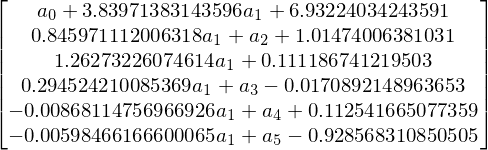

In [19]:
Π0*alpha+alpha4

In [20]:
# df_merged.to_csv('df_merged1.0.csv')

In [22]:
print(eq1_market.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &       l_qu       & \textbf{  R-squared:         } &     0.231   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.231   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     644.2   \\
\textbf{Date:}             & Wed, 15 Aug 2018 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}             &     19:17:22     & \textbf{  Log-Likelihood:    } &   -19086.   \\
\textbf{No. Observations:} &       10738      & \textbf{  AIC:               } & 3.818e+04   \\
\textbf{Df Residuals:}     &       10732      & \textbf{  BIC:               } & 3.823e+04   \\
\textbf{Df Model:}         &           5      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                       & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$>$$|$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\

#### Citroen Own price elasticity

In [26]:
citroen = ['citroen']
df_citroen = df_merged[(df_merged.brand.isin(citroen)) & (df_merged.year.isin(year_selection))] [['brand','year','qu','eurprice','princ','l_steel_pr','l_copper_pr', 'luxurylevel', 'tax', 'home', 'li','population','avdcpr','avdppr','WPU101']]
df_citroen['l_qu'] = np.log(df_citroen.qu)
df_citroen['l_eurprice'] = np.log(df_citroen.eurprice)
df_citroen['l_princ'] = np.log(df_citroen.princ)
df_citroen['l_tax'] = np.log(df_citroen.tax)
df_citroen['l_li'] = np.log(df_citroen.li)
df_citroen['l_population'] = np.log(df_citroen.population)
df_citroen['l_avdcpr'] = np.log(df_citroen.avdcpr)
df_citroen['l_avdppr'] = np.log(df_citroen.avdppr)


#Demand Side
eq1_citroen = smf.ols(formula = 'l_qu ~ l_princ + l_steel_pr + l_copper_pr + luxurylevel +l_population', data = df_citroen).fit()
#print(eq1_peugeot.summary())

#Supply side
eq2_citroen = smf.ols(formula = 'l_eurprice ~ l_princ + l_steel_pr + l_copper_pr+ luxurylevel +l_population', data = df_citroen).fit()


Π1 = sy.Matrix(np.array([eq1_citroen.params.tolist(),eq2_citroen.params.tolist()]).T)

sy.solve(Π1*alpha+alpha4, (a_0,a_1,a_2,a_3,a_4,a_5))

# sy.solve(Π1*beta-beta5, (b_0,b_1,b_2,b_3))

In [31]:
eq1_citroen.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   l_qu   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     49.65
Date:                Wed, 15 Aug 2018   Prob (F-statistic):           2.80e-44
Time:                        20:21:37   Log-Likelihood:                -1132.7
No. Observations:                 734   AIC:                             2277.
Df Residuals:                     728   BIC:                             2305.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4508      1.188      0.379      0.704      -1.882       2.783
l_princ         -1.1453      0.104    -11.045      0.000      -1.349      -0.942
l_steel_pr      -0.3290      0.135     -2.430      0.015      -0.595      -0.063
l_copper_pr      0.4047      0.204      1.987      0.047       0.005       0.805
luxurylevel     -0.3553      0.037     -9.650      0.000      -0.428      -0.283
l_population     0.6275      0.058     10.809      0.000       0.514       0.741
==============================================================================
Omnibus:                       20.884   Durbin-Watson:                   0.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.095
Skew:                          -0.393   Prob(JB):                     1.59e-05
Kurtosis:                       3.325   Cond. No.                         527.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
print(eq1_citroen.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &       l_qu       & \textbf{  R-squared:         } &     0.254   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.249   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     49.65   \\
\textbf{Date:}             & Wed, 15 Aug 2018 & \textbf{  Prob (F-statistic):} &  2.80e-44   \\
\textbf{Time:}             &     19:22:12     & \textbf{  Log-Likelihood:    } &   -1132.7   \\
\textbf{No. Observations:} &         734      & \textbf{  AIC:               } &     2277.   \\
\textbf{Df Residuals:}     &         728      & \textbf{  BIC:               } &     2305.   \\
\textbf{Df Model:}         &           5      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                       & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$>$$|$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\

In [23]:
df_citroen.to_csv('df_citroen1.0.csv')

In [24]:
df_citroen.fillna(df_citroen.mean())

,brand,year,qu,eurprice,princ,l_steel_pr,l_copper_pr,luxurylevel,tax,home,li,population,avdcpr,avdppr,WPU101,l_qu,l_eurprice,l_princ,l_tax,l_li,l_population,l_avdcpr,l_avdppr
175,citroen,1970,3500,1563.723772,0.451988,3.524398,-0.476348,5,0.250000,0,5.500000,9660000,31.504833,86.973483,33.933333,8.160518,7.354825,-0.794100,-1.386294,1.704748,16.083504,3.450141,4.411493
176,citroen,1971,3987,1627.506678,0.422252,3.581665,-0.701234,5,0.250000,0,5.400000,9670000,32.875366,86.973483,35.933333,8.290794,7.394804,-0.862152,-1.386294,1.686399,16.084539,3.492724,4.411493
177,citroen,1972,5944,1791.357324,0.408968,3.634291,-0.704830,5,0.250000,0,5.400000,9710000,34.666252,86.973483,37.875000,8.690138,7.490729,-0.894117,-1.386294,1.686399,16.088667,3.545767,4.411493
178,citroen,1973,5069,1892.604447,0.371610,3.693245,-0.263655,5,0.250000,0,5.400000,9740000,37.077389,86.973483,40.175000,8.530899,7.545709,-0.989911,-1.386294,1.686399,16.091752,3.613007,4.411493
179,citroen,1974,7421,2021.272945,0.334677,3.963983,-0.109567,5,0.250000,0,5.400000,9770000,41.778015,86.973483,52.666667,8.912069,7.611483,-1.094589,-1.386294,1.686399,16.094827,3.732370,4.411493
180,citroen,1975,6784,2595.712445,0.380864,4.081906,-0.578336,5,0.250000,0,5.800000,9790000,47.112320,86.973483,59.258333,8.822322,7.861616,-0.965312,-1.386294,1.757858,16.096872,3.852535,4.411493
181,citroen,1976,6422,2573.151903,0.325565,4.154054,-0.435926,5,0.250000,0,5.800000,9810000,51.429401,86.973483,63.691667,8.767485,7.852887,-1.122192,-1.386294,1.757858,16.098913,3.940210,4.411493
182,citroen,1977,214,2727.068795,0.301399,4.218649,-0.498578,5,0.250000,0,5.800000,9820000,55.084106,86.973483,67.941667,5.365976,7.910983,-1.199320,-1.386294,1.757858,16.099932,4.008861,4.411493
183,citroen,1978,4462,2987.310136,0.289345,4.314706,-0.463950,5,0.250000,0,5.800000,9830000,57.546692,86.973483,74.791667,8.403352,8.002129,-1.240137,-1.386294,1.757858,16.100949,4.052597,4.411493
184,citroen,1979,4772,3326.518428,0.290857,4.426343,-0.118584,5,0.250000,0,6.600000,9840000,60.118504,86.973483,83.625000,8.470521,8.109682,-1.234924,-1.386294,1.887070,16.101966,4.096318,4.411493


In [25]:
print(eq1_citroen.summary())

                            OLS Regression Results                            
Dep. Variable:                   l_qu   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     49.65
Date:                Wed, 25 Jul 2018   Prob (F-statistic):           2.80e-44
Time:                        10:28:09   Log-Likelihood:                -1132.7
No. Observations:                 734   AIC:                             2277.
Df Residuals:                     728   BIC:                             2305.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4508      1.188      0.379   

## Elasticities with Profit Margin

In [115]:
df_margins = pd.read_excel('ProfitMargin.xlsx')

In [116]:
df_margins

,Firm\Year,Citroen,Peugeot,VW,Fiat,GM,Renault,BWM,Ford,Honda,Mazda,Mercedes,Nissan,Rover,Saab,Toyota,Volvo
0,2012,1.81,-9.22,12.81,1.81,-18.85,5.41,10.12,5.72,3.24,-2.71,0.92,5.63,10.54,2.62,2.33,5.06
1,2013,-0.16,-4.13,6.12,1.17,4.80,2.71,10.32,9.78,4.95,1.77,2.39,5.37,10.61,3.00,6.36,1.73
2,2014,-3.44,-1.22,7.07,1.22,2.72,5.09,10.77,0.86,7.47,3.62,1.75,5.05,12.90,4.30,9.50,1.80
3,2015,6.54,2.44,-0.59,0.23,6.17,7.20,9.96,6.86,6.05,6.90,2.24,6.10,11.90,-2.50,10.62,6.53
4,2016,1.08,4.34,3.24,2.80,8.05,8.76,10.23,4.48,4.35,4.90,2.59,6.01,7.01,0.13,10.50,6.33
5,2017,1.83,4.37,5.58,5.51,8.15,10.17,10.70,5.20,7.19,4.00,1.38,8.24,5.79,39.14,7.95,8.43


In [117]:
elasticity_citroen = -1/df_margins['Citroen'].mean()

In [118]:
elasticity_citroen

In [119]:
elasticity_market = df_margins.mean().drop('Firm\Year')

In [120]:
elasticity_m = -1/elasticity_market.mean()
elasticity_m

### Market Shares

To get the market shares, we have to play with the data as follows. First, we sample by firm selection and year selection.

In [12]:
year_selection2=[75,76]
df_selected = df[(df.frm.isin(firm_selection)) & (df.ye.isin(year_selection2))]
df_selected.head()

,ye,ma,co,zcode,brd,type,brand,model,org,loc,cla,home,frm,qu,cy,hp,we,pl,do,le,wi,he,li1,li2,li3,li,sp,ac,pr,princ,eurpr,exppr,avexr,avdexr,avcpr,avppr,avdcpr,avdppr,xexr,tax,population,ngdp,rgdp,engdp,ergdp,engdpc,ergdpc,year,eurprice,gdppp,revenue
79,75,Belgium,13,15,Audi,audi 80/90,audi,80/90,Germany,Germany,intermediate,0,VW,2513,1297.0,44.0,835,5.0,2.0,419.0,160.0,136.0,8.6,8.6,8.6,8.6,145.0,16.5,163812.5,0.693323,3647.1238,54579.871,3.001335,44.915531,63.378105,65.215988,47.112320,NaN,14.965182,0.25,9790000,2313099935744,4.682313e+12,51498889216,1.042471e+11,5260.3564,10648.324,1975,4725.213595,6815.317752,1.187446e+07
80,76,Belgium,13,15,Audi,audi 80/90,audi,80/90,Germany,Germany,intermediate,0,VW,3485,1297.0,44.0,835,5.0,2.0,419.0,160.0,136.0,8.6,8.6,8.6,8.6,145.0,16.5,197500.0,0.735899,4489.2563,68998.789,2.862369,43.993923,66.101212,67.617668,51.429401,NaN,15.369760,0.25,9810000,2632800010240,4.948303e+12,59844628480,1.124770e+11,6100.3701,11465.542,1976,5816.280462,7903.639502,2.026974e+07
104,75,Belgium,15,14,Audi,audi 100/200,audi,100/200,Germany,Germany,standard,0,VW,3599,1588.0,63.0,1050,5.0,2.0,461.0,173.0,142.0,8.9,8.9,8.9,8.9,160.0,13.5,210000.0,0.888807,4675.4429,69968.852,3.001335,44.915531,63.378105,65.215988,47.112320,NaN,14.965182,0.25,9790000,2313099935744,4.682313e+12,51498889216,1.042471e+11,5260.3564,10648.324,1975,6057.503821,6815.317752,2.180096e+07
105,76,Belgium,15,14,Audi,audi 100/200,audi,100/200,Germany,Germany,standard,0,VW,1602,1588.0,63.0,1050,5.0,2.0,461.0,173.0,142.0,8.9,8.9,8.9,8.9,160.0,13.5,231812.5,0.863750,5269.1938,80986.234,2.862369,43.993923,66.101212,67.617668,51.429401,NaN,15.369760,0.25,9810000,2632800010240,4.948303e+12,59844628480,1.124770e+11,6100.3701,11465.542,1976,6826.767487,7903.639502,1.093648e+07
123,75,Belgium,18,17,BMW,BMW 3 (316),BMW,3,Germany,Germany,standard,0,BMW,697,1573.0,66.0,1010,5.0,2.0,435.5,161.0,138.0,9.9,9.9,9.9,9.9,160.0,13.8,212375.0,0.898859,4728.3198,70760.172,3.001335,44.915531,63.378105,65.215988,47.112320,NaN,14.965182,0.25,9790000,2313099935744,4.682313e+12,51498889216,1.042471e+11,5260.3564,10648.324,1975,6126.011133,6815.317752,4.269830e+06


Then we choose the columns we are interested in.

In [27]:
df_aggregate = pd.DataFrame(df_selected.groupby(['frm', 'ye'])['revenue', 'qu'].sum()).reset_index()
df_aggregate

,frm,ye,revenue,qu
0,BMW,75,9.607642e+08,147831
1,BMW,76,1.143953e+09,160765
2,DAF,75,5.031716e+07,15903
3,Fiat,75,4.137401e+09,1136180
4,Fiat,76,3.094586e+09,826250
5,Ford,75,2.251482e+09,566575
6,Ford,76,3.239960e+09,752401
7,GeneralMotors,75,2.295052e+09,524501
8,GeneralMotors,76,2.781007e+09,582888
9,Honda,75,5.095400e+07,16014


We arrange the dataframe so that we can loop to find out market shares.

In [28]:
df_agg = df_aggregate.pivot(index='frm', columns = 'ye', values = 'revenue')
df_agg

ye,75,76
frm,,
BMW,9.607642e+08,1.143953e+09
DAF,5.031716e+07,NaN
Fiat,4.137401e+09,3.094586e+09
Ford,2.251482e+09,3.239960e+09
GeneralMotors,2.295052e+09,2.781007e+09
Honda,5.095400e+07,9.815443e+07
Mazda,9.528925e+07,2.087018e+08
Mercedes,1.488159e+09,1.650520e+09
Nissan,3.578000e+08,4.109053e+08


In [29]:
for year in year_selection2:
    df_agg['ms'+str(year)] =df_agg[year]/df_agg[year].sum()
df_agg

ye,75,76,ms75,ms76
frm,,,,
BMW,9.607642e+08,1.143953e+09,0.043990,0.043284
DAF,5.031716e+07,NaN,0.002304,NaN
Fiat,4.137401e+09,3.094586e+09,0.189439,0.117091
Ford,2.251482e+09,3.239960e+09,0.103088,0.122591
GeneralMotors,2.295052e+09,2.781007e+09,0.105083,0.105226
Honda,5.095400e+07,9.815443e+07,0.002333,0.003714
Mazda,9.528925e+07,2.087018e+08,0.004363,0.007897
Mercedes,1.488159e+09,1.650520e+09,0.068138,0.062451
Nissan,3.578000e+08,4.109053e+08,0.016383,0.015548


As we see, market shares sum up 1.

In [30]:
df_agg['ms76'].sum()

### Herfindahl–Hirschman Index

In [31]:
shares75 = (df_agg['ms75']*100)**2
shares76 = (df_agg['ms76']*100)**2

In [34]:
ms = pd.read_excel('Market Shares.xlsx')

In [35]:
ms75 = (ms['ms75']*100)**2
ms76 = (ms['ms76']*100)**2

In [36]:
ms75.sum()

In [37]:
ms76.sum()

### Fiat shares
In order to get the shares within Fiat's brands. We do the same as above but just for Fiat.

In [38]:
fiat_brands = ['Fiat']
df_sel = df[(df.frm.isin(fiat_brands)) & (df.ye.isin(year_selection2))]
df_sel.head()

,ye,ma,co,zcode,brd,type,brand,model,org,loc,cla,home,frm,qu,cy,hp,we,pl,do,le,wi,he,li1,li2,li3,li,sp,ac,pr,princ,eurpr,exppr,avexr,avdexr,avcpr,avppr,avdcpr,avdppr,xexr,tax,population,ngdp,rgdp,engdp,ergdp,engdpc,ergdpc,year,eurprice,gdppp,revenue
180,75,Belgium,26,35,Citroën,citroen 2 CV 6 - 2 CV 4,citroen,2CV6,France,France,subcompact,0,Fiat,6784,435.0,18.0,560,4.0,4.0,383.0,148.0,160.0,5.8,5.8,5.8,5.8,102.0,NaN,89987.5,0.380864,2003.4829,17317.24400,5.19641,44.915531,32.948399,NaN,47.11232,NaN,8.643570,0.25,9790000,2313099935744,4.682313e+12,51498889216,1.042471e+11,5260.3564,10648.324,1975,2595.712445,6815.317752,1.760931e+07
228,75,Belgium,30,26,Citroën,citroen CX,citroen,CX,France,France,standard,0,Fiat,3652,1985.0,75.0,1265,5.0,4.0,466.0,173.0,136.0,8.2,8.2,8.2,8.2,174.0,13.1,272887.5,1.154973,6075.5708,52514.62500,5.19641,44.915531,32.948399,NaN,47.11232,NaN,8.643570,0.25,9790000,2313099935744,4.682313e+12,51498889216,1.042471e+11,5260.3564,10648.324,1975,7871.509528,6815.317752,2.874675e+07
268,75,Belgium,35,30,Citroën,citroen GSA/GSX,citroen,GSA,France,France,intermediate,0,Fiat,8122,1222.0,44.0,930,5.0,4.0,412.0,161.0,135.0,9.3,9.3,9.3,9.3,151.0,16.1,174500.0,0.738556,3885.0703,33580.87900,5.19641,44.915531,32.948399,NaN,47.11232,NaN,8.643570,0.25,9790000,2313099935744,4.682313e+12,51498889216,1.042471e+11,5260.3564,10648.324,1975,5033.497081,6815.317752,4.088206e+07
280,75,Belgium,36,36,Citroën,citroen dyane,citroen,dyane,France,France,subcompact,0,Fiat,5443,602.0,23.5,600,4.0,5.0,387.0,150.0,154.0,6.1,6.1,6.1,6.1,120.0,NaN,96900.0,0.410121,2157.3828,18647.49000,5.19641,44.915531,32.948399,NaN,47.11232,NaN,8.643570,0.25,9790000,2313099935744,4.682313e+12,51498889216,1.042471e+11,5260.3564,10648.324,1975,2795.105156,6815.317752,1.521376e+07
363,75,Belgium,50,70,Fiat,fiat 126,fiat,126,Italy,Italy,subcompact,0,Fiat,2238,594.0,17.0,580,4.0,2.0,305.5,137.5,133.5,5.4,5.4,5.4,5.4,105.0,47.0,83687.5,0.354200,1863.2196,105.65592,792.07581,44.915531,18.225000,NaN,47.11232,NaN,0.056706,0.25,9790000,2313099935744,4.682313e+12,51498889216,1.042471e+11,5260.3564,10648.324,1975,2413.987314,6815.317752,5.402504e+06


In [39]:
df_aggregate_fiat = pd.DataFrame(df_sel.groupby(['brand', 'ye'])['revenue', 'qu'].sum()).reset_index()
df_aggregate_fiat

,brand,ye,revenue,qu
0,citroen,75,1.335107e+09,314321
1,fiat,75,2.371140e+09,714805
2,fiat,76,2.609645e+09,724237
3,lancia,75,4.311533e+08,107054
4,lancia,76,4.849402e+08,102013


In [40]:
df_agg_fiat = df_aggregate_fiat.pivot(index='brand', columns = 'ye', values = 'revenue')
df_agg_fiat

ye,75,76
brand,,
citroen,1.335107e+09,NaN
fiat,2.371140e+09,2.609645e+09
lancia,4.311533e+08,4.849402e+08


In [41]:
for year in year_selection2:
    df_agg_fiat['ms'+str(year)] =df_agg_fiat[year]/df_agg_fiat[year].sum()
df_agg_fiat

ye,75,76,ms75,ms76
brand,,,,
citroen,1.335107e+09,NaN,0.322692,NaN
fiat,2.371140e+09,2.609645e+09,0.573099,0.843294
lancia,4.311533e+08,4.849402e+08,0.104209,0.156706


In [42]:
0.10420868178082854*0.189439 #Lancia75

In [43]:
0.32269299560110215*0.189439 #Citroen

In [44]:
0.573099047711123*0.189439 #Fiat75

In [45]:
0.843294*0.117091 #Fiat76

In [46]:
0.156706*0.117091 #Lancia 76

### Peugeot shares
In order to get Peugeot shares in 1976, differentiating Citröen and Peugeot as brands owned by Peugeot.

In [47]:
peugeot_firms = ['Peugeot']
df_sel1 = df[(df.frm.isin(peugeot_firms)) & (df.ye.isin(year_selection2))]
df_sel1.head()

,ye,ma,co,zcode,brd,type,brand,model,org,loc,cla,home,frm,qu,cy,hp,we,pl,do,le,wi,he,li1,li2,li3,li,sp,ac,pr,princ,eurpr,exppr,avexr,avdexr,avcpr,avppr,avdcpr,avdppr,xexr,tax,population,ngdp,rgdp,engdp,ergdp,engdpc,ergdpc,year,eurprice,gdppp,revenue
181,76,Belgium,26,35,Citroën,citroen 2 CV 6 - 2 CV 4,citroen,2CV6,France,France,subcompact,0,Peugeot,6422,435.0,18.0,560,4.0,4.0,383.0,148.0,160.0,5.8,5.8,5.8,5.8,102.0,33.5,87375.0,0.325565,1986.0697,15668.042,5.576638,43.993923,36.119846,NaN,51.429401,NaN,7.888968,0.25,9810000,2632800010240,4.948303e+12,59844628480,1.124770e+11,6100.3701,11465.542,1976,2573.151903,7903.639502,1.652478e+07
229,76,Belgium,30,26,Citroën,citroen CX,citroen,CX,France,France,standard,0,Peugeot,4672,1985.0,75.0,1265,5.0,4.0,466.0,173.0,136.0,8.2,8.2,8.2,8.2,174.0,13.1,287375.0,1.070780,6532.1523,51531.941,5.576638,43.993923,36.119846,NaN,51.429401,NaN,7.888968,0.25,9810000,2632800010240,4.948303e+12,59844628480,1.124770e+11,6100.3701,11465.542,1976,8463.056520,7903.639502,3.953940e+07
281,76,Belgium,36,36,Citroën,citroen dyane,citroen,dyane,France,France,subcompact,0,Peugeot,4980,602.0,24.0,600,4.0,5.0,387.0,150.0,154.0,6.1,6.1,6.1,6.1,120.0,NaN,106125.0,0.395429,2412.2649,19030.283,5.576638,43.993923,36.119846,NaN,51.429401,NaN,7.888968,0.25,9810000,2632800010240,4.948303e+12,59844628480,1.124770e+11,6100.3701,11465.542,1976,3125.330404,7903.639502,1.556415e+07
289,76,Belgium,37,313,Citroën,citroen G/GS special,citroen,G special,France,France,intermediate,0,Peugeot,8096,1015.0,40.5,930,5.0,5.0,412.0,161.0,135.0,9.3,9.3,9.3,9.3,151.0,16.1,162437.5,0.605254,3692.2712,29128.213,5.576638,43.993923,36.119846,NaN,51.429401,NaN,7.888968,0.25,9810000,2632800010240,4.948303e+12,59844628480,1.124770e+11,6100.3701,11465.542,1976,4783.706567,7903.639502,3.872889e+07
1387,75,Belgium,184,210,Peugeot,peugeot 104,peugeot,104,France,France,subcompact,0,Peugeot,2527,954.0,34.0,760,4.0,4.0,358.0,152.0,139.0,8.2,8.2,8.2,8.2,135.0,20.5,135500.0,0.573492,3016.7739,26075.695,5.196410,44.915531,32.948399,NaN,47.112320,NaN,8.643570,0.25,9790000,2313099935744,4.682313e+12,51498889216,1.042471e+11,5260.3564,10648.324,1975,3908.532265,6815.317752,9.876861e+06


In [48]:
df_aggregate_peugeot = pd.DataFrame(df_sel1.groupby(['brand', 'ye'])['revenue', 'qu'].sum()).reset_index()
df_aggregate_peugeot

,brand,ye,revenue,qu
0,citroen,76,2.093216e+09,443237
1,peugeot,75,1.891862e+09,382964
2,peugeot,76,2.357776e+09,416029


In [49]:
df_agg_peugeot = df_aggregate_peugeot.pivot(index='brand', columns = 'ye', values = 'revenue')
df_agg_peugeot

ye,75,76
brand,,
citroen,NaN,2.093216e+09
peugeot,1.891862e+09,2.357776e+09


In [50]:
for year in year_selection2:
    df_agg_peugeot['ms'+str(year)] =df_agg_peugeot[year]/df_agg_peugeot[year].sum()
df_agg_peugeot

ye,75,76,ms75,ms76
brand,,,,
citroen,NaN,2.093216e+09,NaN,0.470281
peugeot,1.891862e+09,2.357776e+09,1.0,0.529719


In [51]:
0.470281*0.168414 #CItroen76

In [52]:
0.529719*0.168414 #Peugeot76

### Price increases

To get the observed price increases.

In [53]:
dfff=pd.DataFrame(df_selected.groupby(['frm','ye'])['eurprice'].mean()).reset_index()

dfff_agg = dfff.pivot(index='frm', columns = 'ye', values = 'eurprice')
dfff_agg['delta'] = (dfff_agg[76]-dfff_agg[75])/dfff_agg[75]
dfff_agg

ye,75,76,delta
frm,,,
BMW,7619.210154,7310.996243,-0.040452
DAF,3083.797398,NaN,NaN
Fiat,4451.258320,4548.299275,0.021801
Ford,4398.084923,4640.419022,0.055100
GeneralMotors,5033.341567,5876.645041,0.167543
Honda,3400.388390,3844.694101,0.130663
Mazda,3931.280127,4432.566795,0.127512
Mercedes,8754.944913,9532.816675,0.088849
Nissan,3950.883764,4481.242158,0.134238


In [54]:
dfff_fiat = pd.DataFrame(df_sel.groupby(['brand', 'ye'])['eurprice'].mean()).reset_index()
dfff_fiat = dfff_fiat.pivot(index='brand', columns = 'ye', values = 'eurprice')
dfff_fiat['delta'] = (dfff_fiat[76]-dfff_fiat[75])/dfff_fiat[75]
dfff_fiat

ye,75,76,delta
brand,,,
citroen,4288.263105,NaN,NaN
fiat,4325.703894,4131.719659,-0.044845
lancia,5157.315735,5589.748313,0.083848


In [55]:
dfff_peugeot = pd.DataFrame(df_sel1.groupby(['brand', 'ye'])['eurprice'].mean()).reset_index()
dfff_peugeot = dfff_peugeot.pivot(index='brand', columns = 'ye', values = 'eurprice')
dfff_peugeot['delta'] = (dfff_peugeot[76]-dfff_peugeot[75])/dfff_peugeot[75]
dfff_peugeot

ye,75,76,delta
brand,,,
citroen,NaN,4807.684552,NaN
peugeot,5210.234912,6295.579728,0.20831


### Simulations

We begin with a class definition in order to get nice tables below.

In [33]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in
        IPython Notebook. """

    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")

            for col in row:
                html.append("<td>{0}</td>".format(col))

            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

We introduce the market shares and the elasticities by creating dictionaries.

In [13]:
market_share = {} # creates a dictionary with market shares
elasticity = {}   # dictionaries of firm level own and cross elasticities

firms = ['Citroen','Peugeot','VW', 'Lancia', 'Fiat', 'GM', 'Renault','BMW','DAF','Ford','Honda','Mazda','Mercedes','Nissan','Rover','Saab','TalbotMantra','Toyota','Volvo'] # names of the firms in a python list
market_share['Peugeot'] = 0.086623
market_share['VW'] = 0.144665
market_share['Lancia'] = 0.019741188467878378
market_share['Fiat'] = 0.10856731049934742
market_share['GM'] = 0.105083
market_share['Renault'] =  0.141336
market_share['BMW'] = 0.043990
market_share['DAF'] = 0.002304
market_share['Ford'] =  0.103088
market_share['Honda'] = 0.002333
market_share['Mazda'] = 0.004363
market_share['Mercedes'] = 0.068138
market_share['Nissan'] =  0.016383 
market_share['Rover'] = 0.066316 
market_share['Saab'] = 0.002234
market_share['Volvo'] = 0.013586
market_share['Toyota'] = 0.008152
market_share['TalbotMantra'] = 0.001967
market_share['Citroen'] = 1 - sum(market_share[firm] for firm in ['Peugeot','VW', 'Lancia', 'Fiat', 'GM', 'Renault','BMW','DAF','Ford','Honda','Mazda','Mercedes','Nissan','Rover','Saab','TalbotMantra','Toyota','Volvo'])

for firm in firms:
    if (market_share[firm] >= 0 and market_share[firm] <= 1):
        print ("market share of firm: "+ firm + " is given by %1.2f" % market_share[firm])
    else: print ("something wrong with the market share of the firm: "+firm)

market_elasticity = -0.0880525069928945 # market demand elasticity STRUCTURAL MODELLING (Rosal way)
elasticity['Citroen','Citroen'] = -0.2841417099625 # own elasticity of firm1 STRUCTURAL MODELLING (Rosal way)

# market_elasticity = -0.20059761372422005 # market demand elasticity PROFIT APPROXIMATION
# elasticity['Citroen','Citroen'] = -0.7832898172323759 # own elasticity of firm1 PROFIT APPROXIMATION

# market_elasticity = -1.0 # market demand elasticity EXAMPLE STARTING POINT
# elasticity['Citroen','Citroen'] = -3.0 # own elasticity of firm1 EXAMPLE STARTING POINT

if market_elasticity < elasticity['Citroen','Citroen']:
    print ("error: a firm's own elasticity exceeds (in absolute value) the market elasticity")

market share of firm: Citroen is given by 0.06
market share of firm: Peugeot is given by 0.09
market share of firm: VW is given by 0.14
market share of firm: Lancia is given by 0.02
market share of firm: Fiat is given by 0.11
market share of firm: GM is given by 0.11
market share of firm: Renault is given by 0.14
market share of firm: BMW is given by 0.04
market share of firm: DAF is given by 0.00
market share of firm: Ford is given by 0.10
market share of firm: Honda is given by 0.00
market share of firm: Mazda is given by 0.00
market share of firm: Mercedes is given by 0.07
market share of firm: Nissan is given by 0.02
market share of firm: Rover is given by 0.07
market share of firm: Saab is given by 0.00
market share of firm: TalbotMantra is given by 0.00
market share of firm: Toyota is given by 0.01
market share of firm: Volvo is given by 0.01


We get the b's by coding Epstein and Rubinfeld (2001)'s equations. 

In [91]:
b = {} # dictionary of b-coefficients of demand system (D) above
b['Citroen','Citroen'] = market_share['Citroen']*(elasticity['Citroen','Citroen']+1-market_share['Citroen']*(market_elasticity+1))

for firm in firms:
    b[firm,firm]=(market_share[firm]*(1-market_share[firm]))/(market_share['Citroen']*(1-market_share['Citroen']))*b['Citroen','Citroen']

for one_firm in firms:
    for other_firm in firms:
        if one_firm == other_firm:
            b[one_firm,one_firm]=(market_share[one_firm]*(1-market_share[one_firm]))/(market_share['Citroen']*(1-market_share['Citroen']))*b['Citroen','Citroen']
        else:
            b[one_firm,other_firm] = - market_share[one_firm]/(1-market_share[other_firm])*b[other_firm,other_firm]

for one_firm in firms:
    for other_firm in firms:
        if one_firm == other_firm:
            elasticity[one_firm,one_firm] = -1 + b[one_firm,one_firm]/market_share[one_firm]+market_share[one_firm]*(market_elasticity+1)
        else:
            elasticity[one_firm,other_firm] = b[one_firm,other_firm]/market_share[one_firm]+market_share[other_firm]*(market_elasticity+1)

table = ListTable()
table.append(['b-coeff.', 'Citroen','Peugeot','VW', 'Lancia', 'Fiat', 'GM', 'Renault','BMW','DAF','Ford','Honda','Mazda','Mercedes','Nissan','Rover','Saab','TalbotMantra','Toyota','Volvo'])
for one_firm in firms:
    row = []
    row.append(one_firm)
    for other_firm in firms:
        row.append("%0.3f" % b[one_firm,other_firm])
    table.append(row)
print ("table of b coefficients:")
table

table of b coefficients:


b-coeff.,Citroen,Peugeot,VW,Lancia,Fiat,GM,Renault,BMW,DAF,Ford,Honda,Mazda,Mercedes,Nissan,Rover,Saab,TalbotMantra,Toyota,Volvo
Citroen,0.040,-0.004,-0.006,-0.001,-0.005,-0.005,-0.006,-0.002,-0.000,-0.004,-0.000,-0.000,-0.003,-0.001,-0.003,-0.000,-0.000,-0.000,-0.001
Peugeot,-0.004,0.056,-0.009,-0.001,-0.007,-0.006,-0.009,-0.003,-0.000,-0.006,-0.000,-0.000,-0.004,-0.001,-0.004,-0.000,-0.000,-0.000,-0.001
VW,-0.006,-0.009,0.087,-0.002,-0.011,-0.011,-0.014,-0.004,-0.000,-0.010,-0.000,-0.000,-0.007,-0.002,-0.007,-0.000,-0.000,-0.001,-0.001
Lancia,-0.001,-0.001,-0.002,0.014,-0.002,-0.001,-0.002,-0.001,-0.000,-0.001,-0.000,-0.000,-0.001,-0.000,-0.001,-0.000,-0.000,-0.000,-0.000
Fiat,-0.005,-0.007,-0.011,-0.002,0.068,-0.008,-0.011,-0.003,-0.000,-0.008,-0.000,-0.000,-0.005,-0.001,-0.005,-0.000,-0.000,-0.001,-0.001
GM,-0.005,-0.006,-0.011,-0.001,-0.008,0.066,-0.010,-0.003,-0.000,-0.008,-0.000,-0.000,-0.005,-0.001,-0.005,-0.000,-0.000,-0.001,-0.001
Renault,-0.006,-0.009,-0.014,-0.002,-0.011,-0.010,0.085,-0.004,-0.000,-0.010,-0.000,-0.000,-0.007,-0.002,-0.007,-0.000,-0.000,-0.001,-0.001
BMW,-0.002,-0.003,-0.004,-0.001,-0.003,-0.003,-0.004,0.030,-0.000,-0.003,-0.000,-0.000,-0.002,-0.001,-0.002,-0.000,-0.000,-0.000,-0.000
DAF,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.002,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000
Ford,-0.004,-0.006,-0.010,-0.001,-0.008,-0.008,-0.010,-0.003,-0.000,0.065,-0.000,-0.000,-0.005,-0.001,-0.005,-0.000,-0.000,-0.001,-0.001


In [92]:
table = ListTable()
table.append(['elast.', 'Citroen','Peugeot','VW', 'Lancia', 'Fiat', 'GM', 'Renault','BMW','DAF','Ford','Honda','Mazda','Mercedes','Nissan','Rover','Saab','TalbotMantra','Toyota','Volvo'])
for one_firm in firms:
    row = []
    row.append(one_firm)
    for other_firm in firms:
        row.append("%0.3f" % elasticity[one_firm,other_firm])
    table.append(row)
print ("table of elasticities:")
table

table of elasticities:


elast.,Citroen,Peugeot,VW,Lancia,Fiat,GM,Renault,BMW,DAF,Ford,Honda,Mazda,Mercedes,Nissan,Rover,Saab,TalbotMantra,Toyota,Volvo
Citroen,-0.284,0.018,0.030,0.004,0.023,0.022,0.030,0.009,0.000,0.022,0.000,0.001,0.014,0.003,0.014,0.000,0.000,0.002,0.003
Peugeot,0.013,-0.279,0.030,0.004,0.023,0.022,0.030,0.009,0.000,0.022,0.000,0.001,0.014,0.003,0.014,0.000,0.000,0.002,0.003
VW,0.013,0.018,-0.267,0.004,0.023,0.022,0.030,0.009,0.000,0.022,0.000,0.001,0.014,0.003,0.014,0.000,0.000,0.002,0.003
Lancia,0.013,0.018,0.030,-0.293,0.023,0.022,0.030,0.009,0.000,0.022,0.000,0.001,0.014,0.003,0.014,0.000,0.000,0.002,0.003
Fiat,0.013,0.018,0.030,0.004,-0.274,0.022,0.030,0.009,0.000,0.022,0.000,0.001,0.014,0.003,0.014,0.000,0.000,0.002,0.003
GM,0.013,0.018,0.030,0.004,0.023,-0.275,0.030,0.009,0.000,0.022,0.000,0.001,0.014,0.003,0.014,0.000,0.000,0.002,0.003
Renault,0.013,0.018,0.030,0.004,0.023,0.022,-0.267,0.009,0.000,0.022,0.000,0.001,0.014,0.003,0.014,0.000,0.000,0.002,0.003
BMW,0.013,0.018,0.030,0.004,0.023,0.022,0.030,-0.288,0.000,0.022,0.000,0.001,0.014,0.003,0.014,0.000,0.000,0.002,0.003
DAF,0.013,0.018,0.030,0.004,0.023,0.022,0.030,0.009,-0.296,0.022,0.000,0.001,0.014,0.003,0.014,0.000,0.000,0.002,0.003
Ford,0.013,0.018,0.030,0.004,0.023,0.022,0.030,0.009,0.000,-0.275,0.000,0.001,0.014,0.003,0.014,0.000,0.000,0.002,0.003


We compute the margins with the inequality m=-1/e

In [93]:
margin = {}
for firm in firms:
    margin[firm] = -1.0/elasticity[firm,firm]

We define the merging firms, in our case, Peugeot and Citroen and set efficiency gains if any.

In [100]:
merging_firms = ['Citroen','Peugeot']                      # list of the merging firms
nonmerging_firms = list(set(firms)-set(merging_firms)) # list of non-merging firms
efficiency_gains = {} # dictionary with efficiency gains --due to the merger-- for the firms

# for firm in merging_firms:
#     efficiency_gains[firm] = 0.0
# for firm in nonmerging_firms:
#     efficiency_gains[firm] = 0.0
    
for firm in merging_firms:
    efficiency_gains[firm] = -0.7
for firm in nonmerging_firms:
    efficiency_gains[firm] = 0.0

We create dictionaries to get the post transaction values.

In [101]:
post_marketshare = {}
post_elasticity = {}
post_margin = {}
price_change = {}

def vector_function(post_marketshare,post_elasticity,post_margin,price_change):
    equations = []
    for firm in sorted(firms):
        equations.append(post_marketshare[firm]-(market_share[firm]+sum([b[firm,other_firm]*log(1+price_change[other_firm]) for other_firm in firms])))
        equations.append(post_margin[firm] - (1-(1+efficiency_gains[firm])/(1+price_change[firm])*(1-margin[firm])))
    for firm in sorted(nonmerging_firms):
        equations.append(post_margin[firm] + 1/post_elasticity[firm,firm])
        equations.append(post_elasticity[firm,firm] - (-1 + b[firm,firm]/post_marketshare[firm]+post_marketshare[firm]*(market_elasticity+1)))
    for firm in sorted(merging_firms):
        equations.append(post_marketshare[firm]+sum(post_elasticity[other_firm,firm]*post_marketshare[other_firm]*post_margin[other_firm] for other_firm in sorted(merging_firms)))
        for other_firm in sorted(merging_firms):
            equations.append(post_elasticity[firm,other_firm] - (-(firm==other_firm) + b[firm,other_firm]/post_marketshare[firm]+post_marketshare[other_firm]*(market_elasticity+1)))
    return equations

In [102]:
def wrapper_function(x): # the solver used below needs a vector x as input, not a collection of dictionaries
    counter = 0
    for dict in [post_marketshare,post_margin,price_change]:
        for firm in sorted(firms):
            dict[firm] = x[counter]
            counter +=1
    for firm in sorted(nonmerging_firms):
        post_elasticity[firm, firm] = x[counter]
        counter +=1
    for firm in sorted(merging_firms):
        for other_firm in sorted(merging_firms):
            post_elasticity[firm, other_firm] = x[counter]
            counter +=1
    return vector_function(post_marketshare,post_elasticity,post_margin,price_change)

def unwrap(x):   # once we have the equilibrium solution as a vector x, we go back to dictionaries
    counter = 0  # as they are easier to work with
    for dict in [post_marketshare,post_margin,price_change]:
        for firm in sorted(firms):
            dict[firm] = x[counter]
            counter +=1
    for firm in sorted(nonmerging_firms):
        post_elasticity[firm, firm] = x[counter]
        counter +=1
    for firm in sorted(merging_firms):
        for other_firm in sorted(merging_firms):
            post_elasticity[firm, other_firm] = x[counter]
            counter +=1
    return [post_marketshare,post_elasticity,post_margin,price_change]

In [103]:
def initial_value(): # initial value based on before merger values
    x = []
    for dict in [market_share,margin]:
        for firm in sorted(firms):
            x.append(dict[firm])
    for firm in sorted(firms):
        x.append(0.0) # price change
    for firm in sorted(nonmerging_firms):
        x.append(elasticity[firm, firm])
    for firm in sorted(merging_firms):
        for other_firm in sorted(merging_firms):
            x.append(elasticity[firm, other_firm])
    return x

In [104]:
def after_merger_values():
    outcome = unwrap(optimize.fsolve(wrapper_function, initial_value()))
    table = ListTable()
    table.append(['firm', 'marketshare','margin','price increase'])
    for firm in firms:
        table.append([firm, "%0.3f" % outcome[0][firm],"%0.3f" % outcome[2][firm],"%0.3f" % outcome[3][firm]])
    print ("table of post merger outcomes:")
    return table

In [105]:
after_merger_values()

table of post merger outcomes:


C:\Users\borca\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


firm,marketshare,margin,price increase
Citroen,0.063,1.789,-0.042
Peugeot,0.092,1.790,-0.016
VW,0.145,3.714,0.013
Lancia,0.020,3.334,0.035
Fiat,0.110,3.576,0.027
GM,0.106,3.565,0.028
Renault,0.142,3.700,0.015
BMW,0.044,3.394,0.034
DAF,0.002,3.293,0.035
Ford,0.104,3.559,0.028


In [65]:
df_agg

ye,75,76,ms75,ms76
frm,,,,
BMW,9.607642e+08,1.143953e+09,0.043990,0.043284
DAF,5.031716e+07,NaN,0.002304,NaN
Fiat,4.137401e+09,3.094586e+09,0.189439,0.117091
Ford,2.251482e+09,3.239960e+09,0.103088,0.122591
GeneralMotors,2.295052e+09,2.781007e+09,0.105083,0.105226
Honda,5.095400e+07,9.815443e+07,0.002333,0.003714
Mazda,9.528925e+07,2.087018e+08,0.004363,0.007897
Mercedes,1.488159e+09,1.650520e+09,0.068138,0.062451
Nissan,3.578000e+08,4.109053e+08,0.016383,0.015548
